# Import of data and libraries 

In [4]:
import gudhi
import matplotlib.pyplot as plt

from gudhi.datasets.remote import fetch_spiral_2d
from gudhi.clustering.tomato import Tomato

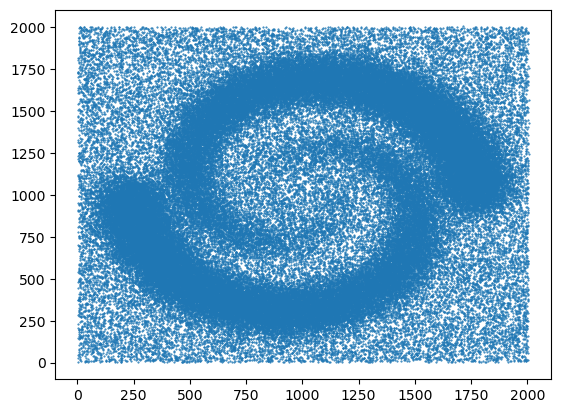

In [3]:
data = fetch_spiral_2d()

plt.scatter(data[:,0],data[:,1],marker='.',s=1)
plt.show()

# ToMATo implementation 

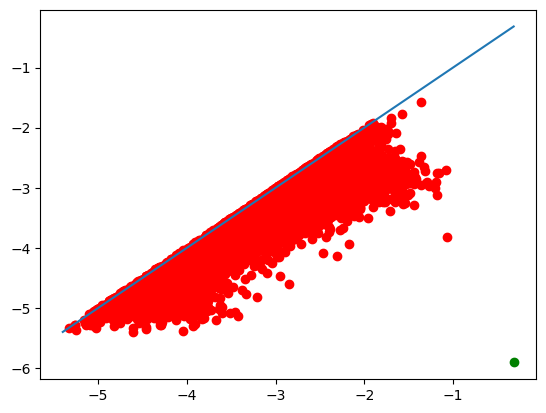

In [5]:
t = Tomato()
t.fit(data)
t.plot_diagram()

We can visualize the results if we choose the number of clusters.

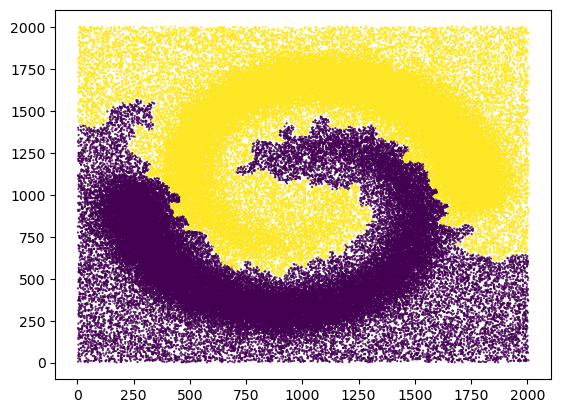

In [6]:
t.n_clusters_=2
plt.scatter(data[:,0],data[:,1],marker='.',s=1,c=t.labels_)
plt.show()

We can play with the hyperparameters (n_clusters_, merge_threshold_, params_). See https://gudhi.inria.fr/python/latest/clustering.html

In [ ]:
class Tomato:
    """
    This clustering algorithm needs a neighborhood graph on the points, and an estimation of the density at each point.
    A few possible graph constructions and density estimators are provided for convenience, but it is perfectly natural
    to provide your own.

    :Requires: `SciPy <installation.html#scipy>`_, `Scikit-learn <installation.html#scikit-learn>`_ or others
        (see :class:`~gudhi.point_cloud.knn.KNearestNeighbors`) in function of the options.

    Attributes
    ----------
    n_clusters_: int
        The number of clusters. Writing to it automatically adjusts `labels_`.
    merge_threshold_: float
        minimum prominence of a cluster so it doesn't get merged. Writing to it automatically adjusts `labels_`.
    n_leaves_: int
        number of leaves (unstable clusters) in the hierarchical tree
    leaf_labels_: ndarray of shape (n_samples,)
        cluster labels for each point, at the very bottom of the hierarchy
    labels_: ndarray of shape (n_samples,)
        cluster labels for each point, after merging
    diagram_: ndarray of shape (`n_leaves_`, 2)
        persistence diagram (only the finite points)
    max_weight_per_cc_: ndarray of shape (n_connected_components,)
        maximum of the density function on each connected component. This corresponds to the abscissa of infinite
        points in the diagram
    children_: ndarray of shape (`n_leaves_`-n_connected_components, 2)
        The children of each non-leaf node. Values less than `n_leaves_` correspond to leaves of the tree.
        A node i greater than or equal to `n_leaves_` is a non-leaf node and has children children_[i - `n_leaves_`].
        Alternatively at the i-th iteration, children[i][0] and children[i][1] are merged to form node `n_leaves_` + i
    weights_: ndarray of shape (n_samples,)
        weights of the points, as computed by the density estimator or provided by the user
    params_: dict
        Parameters like metric, etc
    """

[docs]    def __init__(
        self,
        graph_type="knn",
        density_type="logDTM",
        n_clusters=None,
        merge_threshold=None,
        #       eliminate_threshold=None,
        #           eliminate_threshold (float): minimum max weight of a cluster so it doesn't get eliminated
        **params
    ):
        """
        Args:
            graph_type (str): 'manual', 'knn' or 'radius'. Default is 'knn'.
            density_type (str): 'manual', 'DTM', 'logDTM', 'KDE' or 'logKDE'. When you have many points,
                'KDE' and 'logKDE' tend to be slower. Default is 'logDTM'.
            metric (str|Callable): metric used when calculating the distance between instances in a feature array.
                Defaults to Minkowski of parameter p.
            kde_params (dict): if density_type is 'KDE' or 'logKDE', additional parameters passed directly to
                sklearn.neighbors.KernelDensity.
            k (int): number of neighbors for a knn graph (including the vertex itself). Defaults to 10.
            k_DTM (int): number of neighbors for the DTM density estimation (including the vertex itself).
                Defaults to k.
            r (float): size of a neighborhood if graph_type is 'radius'. Also used as default bandwidth in kde_params.
            eps (float): (1+eps) approximation factor when computing distances (ignored in many cases).
            n_clusters (int): number of clusters requested. Defaults to None, i.e. no merging occurs and we get
                the maximal number of clusters.
            merge_threshold (float): minimum prominence of a cluster so it doesn't get merged.
            symmetrize_graph (bool): whether we should add edges to make the neighborhood graph symmetric.
                This can be useful with k-NN for small k. Defaults to false.
            p (float): norm L^p on input points. Defaults to 2.
            q (float): order used to compute the distance to measure. Defaults to dim.
                Beware that when the dimension is large, this can easily cause overflows.
            dim (float): final exponent in DTM density estimation, representing the dimension. Defaults to the
                dimension, or 2 when the dimension cannot be read from the input (metric is "precomputed").
            n_jobs (int): Number of jobs to schedule for parallel processing on the CPU.
                If -1 is given all processors are used. Default: 1.
            params: extra parameters are passed to :class:`~gudhi.point_cloud.knn.KNearestNeighbors` and
                :class:`~gudhi.point_cloud.dtm.DTMDensity`.
        """
        # Should metric='precomputed' mean input_type='distance_matrix'?
        # Should we be able to pass metric='minkowski' (what None does currently)?
        self.graph_type_ = graph_type
        self.density_type_ = density_type
        self.params_ = params
        self.__n_clusters = n_clusters
        self.__merge_threshold = merge_threshold
        # self.eliminate_threshold_ = eliminate_threshold
        if n_clusters and merge_threshold:
            raise ValueError("Cannot specify both a merge threshold and a number of clusters")


[docs]    def fit(self, X, y=None, weights=None):
        """
        Args:
            X ((n,d)-array of float|(n,n)-array of float|Sequence[Iterable[int]]): coordinates of the points,
                or distance matrix (full, not just a triangle) if metric is "precomputed", or list of neighbors
                for each point (points are represented by their index, starting from 0) if graph_type is "manual".
                The number of points is currently limited to about 2 billion.
            weights (ndarray of shape (n_samples)): if density_type is 'manual', a density estimate at each point
            y: Not used, present here for API consistency with scikit-learn by convention.
        """
        # TODO: First detect if this is a new call with the same data (only threshold changed?)
        # TODO: less code duplication (subroutines?), less spaghetti, but don't compute neighbors twice if not needed. Clear error message for missing or contradictory parameters.
        if weights is not None:
            density_type = "manual"
        else:
            density_type = self.density_type_
            if density_type == "manual":
                raise ValueError("If density_type is 'manual', you must provide weights to fit()")

        if self.graph_type_ == "manual":
            self.neighbors_ = X
            # FIXME: uniformize "message 'option'" vs 'message "option"'
            assert density_type == "manual", 'If graph_type is "manual", density_type must be as well'
        else:
            metric = self.params_.get("metric", "minkowski")
            if metric != "precomputed":
                self.points_ = X

        # Slight complication to avoid computing knn twice.
        need_knn = 0
        need_knn_ngb = False
        need_knn_dist = False
        if self.graph_type_ == "knn":
            k_graph = self.params_.get("k", 10)
            # If X has fewer than k points...
            if k_graph > len(X):
                k_graph = len(X)
            need_knn = k_graph
            need_knn_ngb = True
        if self.density_type_ in ["DTM", "logDTM"]:
            k = self.params_.get("k", 10)
            k_DTM = self.params_.get("k_DTM", k)
            # If X has fewer than k points...
            if k_DTM > len(X):
                k_DTM = len(X)
            need_knn = max(need_knn, k_DTM)
            need_knn_dist = True
            # if we ask for more neighbors for the graph than the DTM, getting the distances is a slight waste,
            # but it looks negligible
        if need_knn > 0:
            knn_args = dict(self.params_)
            knn_args["k"] = need_knn
            knn = KNearestNeighbors(return_index=need_knn_ngb, return_distance=need_knn_dist, **knn_args).fit_transform(
                X
            )
            if need_knn_ngb:
                if need_knn_dist:
                    self.neighbors_ = knn[0][:, 0:k_graph]
                    knn_dist = knn[1]
                else:
                    self.neighbors_ = knn
            elif need_knn_dist:
                knn_dist = knn
        if self.density_type_ in ["DTM", "logDTM"]:
            dim = self.params_.get("dim")
            if dim is None:
                dim = len(X[0]) if metric != "precomputed" else 2
            q = self.params_.get("q", dim)
            weights = DTMDensity(k=k_DTM, metric="neighbors", dim=dim, q=q).fit_transform(knn_dist)
            if self.density_type_ == "logDTM":
                weights = numpy.log(weights)

        if self.graph_type_ == "radius":
            if metric in ["minkowski", "euclidean", "manhattan", "chebyshev"]:
                from scipy.spatial import cKDTree

                tree = cKDTree(X)
                # TODO: handle "l1" and "l2" aliases?
                p = self.params_.get("p")
                if metric == "euclidean":
                    assert p is None or p == 2, "p=" + str(p) + " is not consistent with metric='euclidean'"
                    p = 2
                elif metric == "manhattan":
                    assert p is None or p == 1, "p=" + str(p) + " is not consistent with metric='manhattan'"
                    p = 1
                elif metric == "chebyshev":
                    assert p is None or p == numpy.inf, "p=" + str(p) + " is not consistent with metric='chebyshev'"
                    p = numpy.inf
                elif p is None:
                    p = 2  # the default
                eps = self.params_.get("eps", 0)
                self.neighbors_ = tree.query_ball_tree(tree, r=self.params_["r"], p=p, eps=eps)

            # TODO: sklearn's NearestNeighbors.radius_neighbors can handle more metrics efficiently via its BallTree
            # (don't bother with the _graph variant, it just calls radius_neighbors).
            elif metric != "precomputed":
                from sklearn.metrics import pairwise_distances

                X = pairwise_distances(X, metric=metric, n_jobs=self.params_.get("n_jobs"))
                metric = "precomputed"

            if metric == "precomputed":
                # TODO: parallelize? May not be worth it.
                X = numpy.asarray(X)
                r = self.params_["r"]
                self.neighbors_ = [numpy.flatnonzero(l <= r) for l in X]

        if self.density_type_ in {"KDE", "logKDE"}:
            # Slow...
            assert (
                self.graph_type_ != "manual" and metric != "precomputed"
            ), "Scikit-learn's KernelDensity requires point coordinates"
            kde_params = dict(self.params_.get("kde_params", dict()))
            kde_params.setdefault("metric", metric)
            r = self.params_.get("r")
            if r is not None:
                kde_params.setdefault("bandwidth", r)
            # Should we default rtol to eps?
            from sklearn.neighbors import KernelDensity

            weights = KernelDensity(**kde_params).fit(self.points_).score_samples(self.points_)
            if self.density_type_ == "KDE":
                weights = numpy.exp(weights)

        # TODO: do it at the C++ level and/or in parallel if this is too slow?
        if self.params_.get("symmetrize_graph"):
            self.neighbors_ = [set(line) for line in self.neighbors_]
            for i, line in enumerate(self.neighbors_):
                line.discard(i)
                for j in line:
                    self.neighbors_[j].add(i)

        self.weights_ = weights
        # This is where the main computation happens
        self.leaf_labels_, self.children_, self.diagram_, self.max_weight_per_cc_ = hierarchy(self.neighbors_, weights)
        self.n_leaves_ = len(self.max_weight_per_cc_) + len(self.children_)
        assert self.leaf_labels_.max() + 1 == len(self.max_weight_per_cc_) + len(self.children_)
        # TODO: deduplicate this code with the setters below
        if self.__merge_threshold:
            assert not self.__n_clusters
            self.__n_clusters = numpy.count_nonzero(
                self.diagram_[:, 0] - self.diagram_[:, 1] > self.__merge_threshold
            ) + len(self.max_weight_per_cc_)
        if self.__n_clusters:
            # TODO: set corresponding merge_threshold?
            renaming = merge(self.children_, self.n_leaves_, self.__n_clusters)
            self.labels_ = renaming[self.leaf_labels_]
            # In case the user asked for something impossible.
            # TODO: check for impossible situations before calling merge.
            self.__n_clusters = self.labels_.max() + 1
        else:
            self.labels_ = self.leaf_labels_
            self.__n_clusters = self.n_leaves_
        return self


[docs]    def fit_predict(self, X, y=None, weights=None):
        """
        Equivalent to fit(), and returns the `labels_`.
        """
        return self.fit(X, y, weights).labels_


    # TODO: add argument k or threshold? Have a version where you can click and it shows the line and the corresponding k?
[docs]    def plot_diagram(self):
        """
        """
        import matplotlib.pyplot as plt

        l = self.max_weight_per_cc_.min()
        r = self.max_weight_per_cc_.max()
        if self.diagram_.size > 0:
            plt.plot(self.diagram_[:, 0], self.diagram_[:, 1], "o", color="red")
            l = min(l, self.diagram_[:, 1].min())
            r = max(r, self.diagram_[:, 0].max())
        if l == r:
            if l > 0:
                l, r = 0.9 * l, 1.1 * r
            elif l < 0:
                l, r = 1.1 * l, 0.9 * r
            else:
                l, r = -1.0, 1.0
        plt.plot([l, r], [l, r])
        plt.plot(
            self.max_weight_per_cc_, numpy.full(self.max_weight_per_cc_.shape, 1.1 * l - 0.1 * r), "o", color="green"
        )
        plt.show()


    # Use set_params instead?
    @property
    def n_clusters_(self):
        return self.__n_clusters

    @n_clusters_.setter
    def n_clusters_(self, n_clusters):
        if n_clusters == self.__n_clusters:
            return
        self.__n_clusters = n_clusters
        self.__merge_threshold = None
        if hasattr(self, "leaf_labels_"):
            renaming = merge(self.children_, self.n_leaves_, self.__n_clusters)
            self.labels_ = renaming[self.leaf_labels_]
            # In case the user asked for something impossible
            self.__n_clusters = self.labels_.max() + 1

    @property
    def merge_threshold_(self):
        return self.__merge_threshold

    @merge_threshold_.setter
    def merge_threshold_(self, merge_threshold):
        if merge_threshold == self.__merge_threshold:
            return
        if hasattr(self, "leaf_labels_"):
            self.n_clusters_ = numpy.count_nonzero(self.diagram_[:, 0] - self.diagram_[:, 1] > merge_threshold) + len(
                self.max_weight_per_cc_
            )
        else:
            self.__n_clusters = None
        self.__merge_threshold = merge_threshold

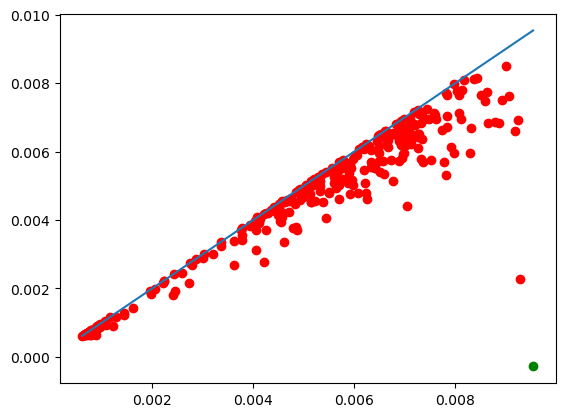

In [7]:
t = Tomato(density_type='DTM', k=100)
t.fit(data)
t.plot_diagram()

A quick look at the corresponding density estimate.

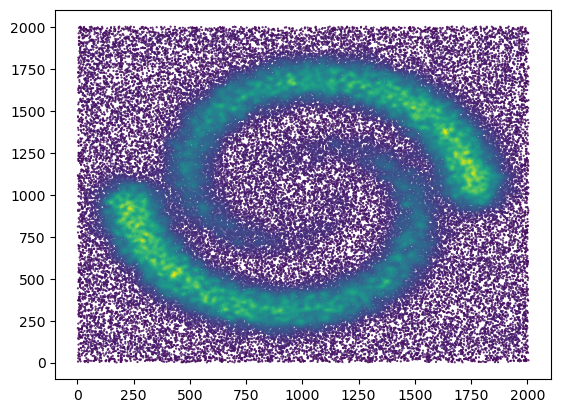

In [8]:
plt.scatter(data[:,0],data[:,1],marker='.',s=1,c=t.weights_)
plt.show()